# Description:

A notebook working through data exploration to answer the question:

"could you use a simple thresholding scheme to automatically create the i-contours, given the o-contours?"


In [46]:
import numpy as np
import load_data
import matplotlib.pyplot as plt

In [7]:
imgs, i_msk, o_msk = load_data.load_all_patients('./final_data')

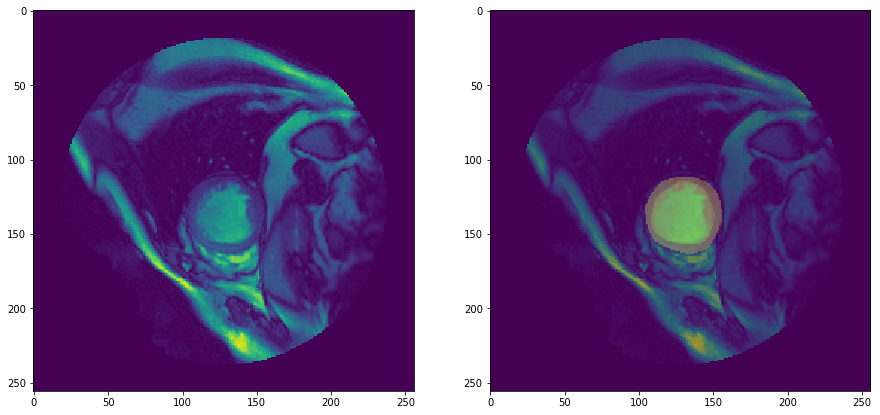

In [142]:
f = plt.figure(figsize=(15,15))
a = f.add_subplot(121)
a.imshow(imgs[1])
b = f.add_subplot(122)
b.imshow(imgs[1])
b.imshow(o_msk[1], alpha=0.3)
b.imshow(i_msk[1], alpha=0.1)
plt.show()

# First task:
Let's explore the intensities of the inner or outer regions by plotting histograms

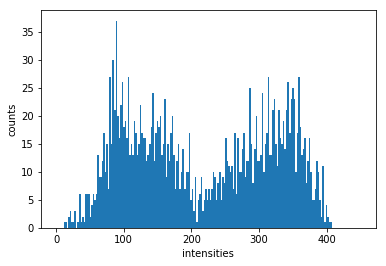

In [118]:
# Histogram of intensities for OUTER mask, ONE image
# intensity vs counts
prod = imgs[1]*o_msk[1]
plt.hist(prod.ravel(), bins=200, range=(0.1, 450))
plt.xlabel('intensities')
plt.ylabel('counts')
plt.show()

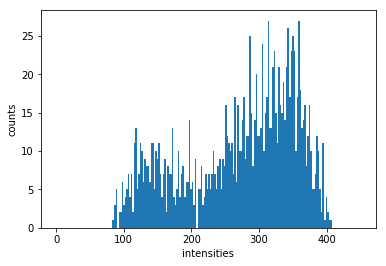

In [117]:
# Histogram of intensities for INNER mask, ONE image
# intensity vs counts
prod = imgs[1]*i_msk[1]
plt.hist(prod.ravel(), bins=200, range=(0.1, 450))
plt.xlabel('intensities')
plt.ylabel('counts')
plt.show()

# Observations:
For a single mri image (patient SC-HF-I-1, image 1), histogram of intensities for pixels from outer contours
show clear separation of intensities at roughly a value of 200.  However, looking at
the histogram of intensities for pixels from inner contours shows a very similar distribution.  The inner contour
mask shows a large number of pixels that overlap outer contour histogram.

Next we can try to aggregate histograms of all images (not just this one)

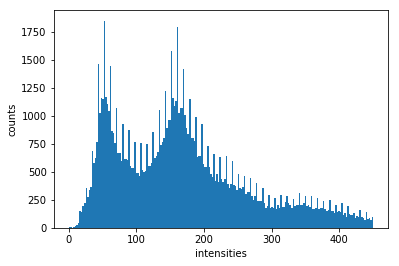

In [8]:
# Histogram of intensities for OUTER mask over ALL patients and labeled images
# intensity vs counts
prod_lst_o = []
for k in range(len(imgs)):
    if type(o_msk[k]) != type(None):
        prod_lst_o.append(imgs[k]*o_msk[k])
        
out = np.asarray(prod_lst_o)
plt.hist(out.ravel(), bins=200, range=(0.1, 450))
plt.xlabel('intensities')
plt.ylabel('counts')
plt.show()

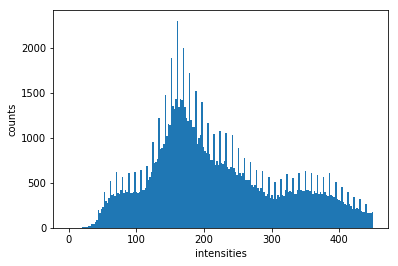

In [9]:
# Histogram of intensities for INNER mask over ALL patients and labeled images
# intensity vs counts
prod_lst_i = []
for k in range(len(imgs)):
    if type(i_msk[k]) != type(None):
        prod_lst_i.append(imgs[k]*i_msk[k])
        
out = np.asarray(prod_lst_i)
plt.hist(out.ravel(), bins=200, range=(0.1, 450))
plt.xlabel('intensities')
plt.ylabel('counts')
plt.show()

# Observations:

As we can see in these two plots, a better threshold for separating the blood from cardiac muscle would be
closer to intensity=100.  We can also see that the distribution of intensities in the blood is VERY large.

By simple thresholding method this means we would get a lot of false negatives (if trying to classify inner).

Follow up questions:
	1) What does the distribution of intensites for ONLY cardiac muscle region look like?  Does it overlap with the blood much?
	2) Can we look at simple metrics to describe these histograms, or the quality of fit for this thresholding model?

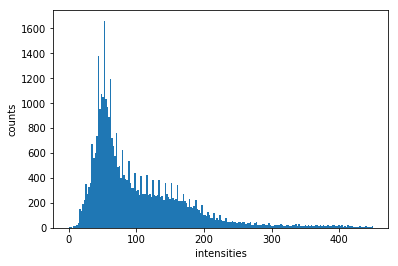

In [10]:
# Distribution of intensities for ONLY cardiac muscle

# Histogram of intensities for outer-inner (cardiac muscle only)
prod_lst_dif = []
for k in range(len(imgs)):
    if type(o_msk[k]) != type(None) and type(i_msk[k])!= type(None):
        prod_lst_dif.append(imgs[k]*(o_msk[k]*np.invert(i_msk[k])))
        
out = np.asarray(prod_lst_dif)
plt.hist(out.ravel(), bins=200, range=(0.1, 450))
plt.xlabel('intensities')
plt.ylabel('counts')
plt.show()

# Observations:

There is a significant tail that bleeds into the high intensity region.
This means a decent amount of cardiac muscle contains high intensity pixels that may be misclassified as blood.

The next step is to look at metrics like precision, recall, F1 score, by varying a threshold on OUTER contour, then calculating vs INNER contour

In [26]:
def predict(image, outer, threshold=100):
    p = outer*image
    p[p < threshold] = 0
    p[p >= threshold] = 1
    return p

def TP(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    return true_positive

def FP(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_positive = np.sum(y_pred) - true_positive
    return false_positive
    
def FN(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_negative = np.sum(y_true) - true_positive
    return false_negative
    
def recall(_TP, _FN):
    true_positive_rate = _TP/(_TP+_FN)
    return true_positive_rate

def precision(_TP, _FP):
    prec = _TP/(_TP+_FP)
    return prec
    
def F1(_recall, _prec):
    F1_ = (_recall * _prec) / (_recall + _prec)
    return F1_

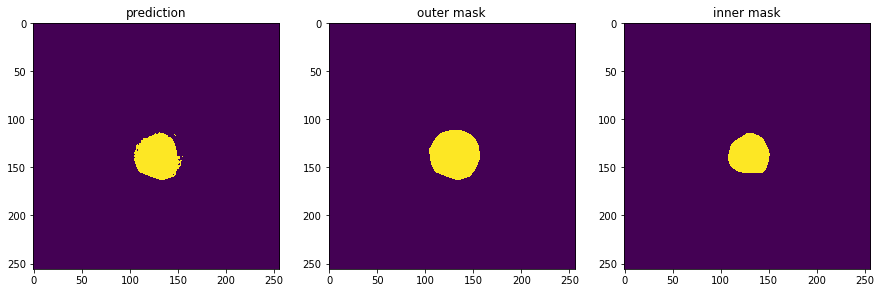

In [13]:
# check that our predictor works, threshold = 100, one image

newim = predict(imgs[1], o_msk[1], threshold=100)

f = plt.figure(figsize=(15,15))
a = f.add_subplot(131)
a.imshow(newim)
plt.title('prediction')
b = f.add_subplot(132)
b.imshow(o_msk[1])
plt.title('outer mask')
c = f.add_subplot(133)
c.imshow(i_msk[1])
plt.title('inner mask')
plt.show()

In [42]:
# manually generate predictions
ground_truth = []
for k in range(len(imgs)):
    if type(o_msk[k]) != type(None) and type(i_msk[k])!= type(None):
        ground_truth.append(i_msk[k])
ground_truth = np.asarray(ground_truth)

thresh = np.arange(0, 500, 10)
metrics = []

for t in thresh:
    
    predictions = []
    for k in range(len(imgs)):
        if type(o_msk[k]) != type(None) and type(i_msk[k])!= type(None):
            predictions.append(predict(imgs[k], o_msk[k], threshold=t))
    predictions = np.asarray(predictions)
    
    TP_ = TP(ground_truth, predictions)
    FP_ = FP(ground_truth, predictions)
    TN_ = TN(ground_truth, predictions)
    FN_ = FN(ground_truth, predictions)
    
    recall_ = recall(TP_, FN_)
    prec_ = precision(TP_, FP_)
    F1_ = F1(recall_, prec_)
    
    metrics.append((prec_, recall_, F1_))
    
    

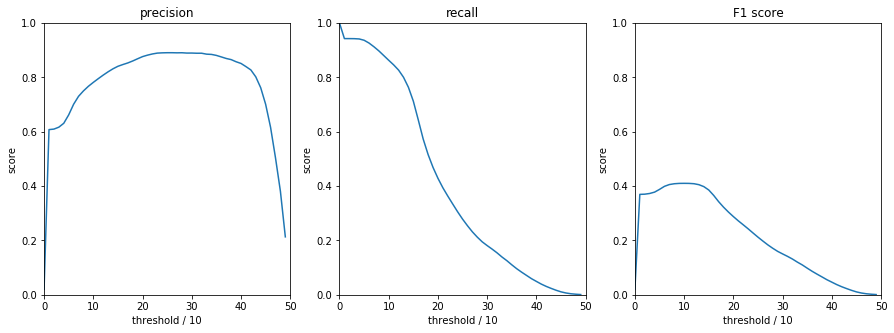

In [45]:
# plot precision, recall, f1
p, r, f = zip(*metrics)

fig = plt.figure(figsize=(15,5))

a = fig.add_subplot(131)
a.plot(p)
plt.title('precision')
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.xlabel('threshold / 10')
plt.ylabel('score')

b = fig.add_subplot(132)
b.plot(r)
plt.title('recall')
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.xlabel('threshold / 10')
plt.ylabel('score')

c = fig.add_subplot(133)
c.plot(f)
plt.title('F1 score')
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.xlabel('threshold / 10')
plt.ylabel('score')
plt.show()

# Observations:

As predicted from visual inspection of the histograms, a threshold around intensity of 100 might be best.

The F1 score here suggests something slightly higher, maybe 130-150, is better.  However, the general behavior is not encouraging.
It shows that thresholding anywhere from 50-150 could produce the same results.  Plus, an F1 score of only 0.4 is quite poor for segmentation tasks.
